<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Particle Steering Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Particle Steering Problem:* We aim to minimize the time taken for a particle, acted upon by a thrust of constant magnitude, to
achieve a given altitude and terminal velocity.
The problem is inspired from the following paper: [Benchmarking Optimization Software with COPS 3.0](https://www.mcs.anl.gov/~more/cops/cops3.pdf).                             
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

In [1]:
import Pkg
Pkg.activate("..")
include("./utils.jl");
using OptimalControlProblems
using Plots
using MKL
import HSL_jll
nh = 100;

  Activating project at `~/ENSEEIHT/Stage/CTBenchmarks.jl`


## 1. Solving with JuMP <a id='jump'></a>

In [ ]:
using JuMP , Ipopt

SteeringJMP = steering(JuMPBackend();nh = nh)

set_optimizer(SteeringJMP,Ipopt.Optimizer)
set_attribute(SteeringJMP, "print_level", 5)
set_optimizer_attribute(SteeringJMP,"tol",1e-8)
set_optimizer_attribute(SteeringJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(SteeringJMP,"max_iter",1000)
set_optimizer_attribute(SteeringJMP,"mu_strategy","adaptive")
#set_attribute(SteeringJMP, "hsllib", HSL_jll.libhsl_path)
#set_attribute(SteeringJMP, "linear_solver", "ma57")
set_optimizer_attribute(SteeringJMP, "print_timing_statistics", "yes")

In [ ]:
println("Solving...")
optimize!(SteeringJMP)
println()

# Display results
if termination_status(SteeringJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(SteeringJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(SteeringJMP) == MOI.TIME_LIMIT && has_values(SteeringJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(SteeringJMP))
println()

h = SteeringJMP[:h];
x_ = SteeringJMP[:x];
u_ = SteeringJMP[:u];

con_x1 = SteeringJMP[:con_x1];
con_x2 = SteeringJMP[:con_x2];
con_x3 = SteeringJMP[:con_x3];
con_x4 = SteeringJMP[:con_x4];

Δtt = value.(h)
t = Vector((0:nh)*Δtt); 

p = - [[ dual(con_x1[i]), dual(con_x2[i]), dual(con_x3[i]), dual(con_x4[i]) ] for i in 1:nh];
p = costateInterpolation(p, t);

x1 = Vector(value.(x_[:,1])) ;
x2 = Vector(value.(x_[:,2])) ;
x3 = Vector(value.(x_[:,3]));
x4 = Vector(value.(x_[:,4])) ;
u = Vector(value.(u_)) ;

x =  [ [ x1[i], x2[i], x3[i], x4[i] ] for i in 1:nh+1] ;

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


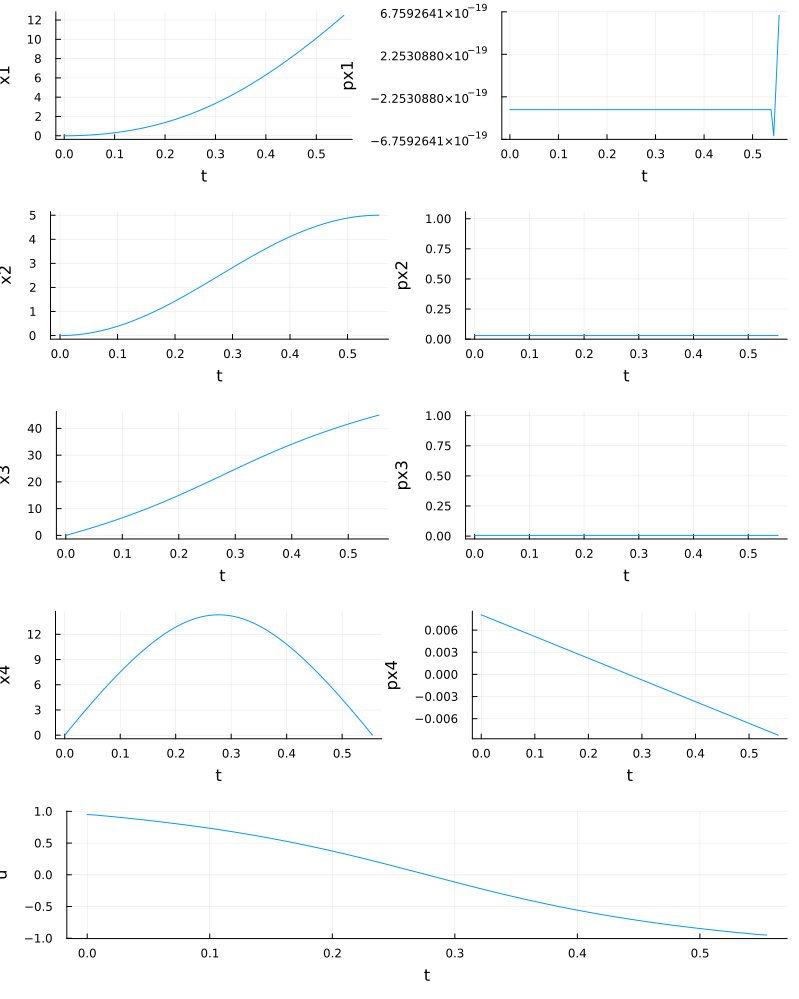

In [4]:
x1_plot = plot(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x1", legend = false)
x2_plot = plot(t, [ x[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "x2", legend = false)
x3_plot = plot(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "x3", legend = false)
x4_plot = plot(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "x4", legend = false)
px1_plot = plot(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "px1", legend = false)
px2_plot = plot(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "px2", legend = false)
px3_plot = plot(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "px3", legend = false)
px4_plot = plot(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "px4", legend = false)
u_plot = plot(t, [ u[i] for i in 1:nh+1 ], xlabel = "t", ylabel = "u", legend = false)

layout = @layout [a b; c d; e f; g h; k]
x_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, x3_plot, px3_plot, x4_plot, px4_plot, u_plot, layout = layout, size = (800, 1000))
display(x_plot)

## 2. Solving with OptimalControl <a id='oc'></a>

In [5]:
using OptimalControl, NLPModelsIpopt
docp, SteeringOC = steering(OptimalControlBackend();nh = nh);

In [ ]:
# Solve the problem
nlp_sol = NLPModelsIpopt.ipopt(
    SteeringOC;
    print_level=5,
    tol=1e-8,
    mu_strategy="adaptive",
    sb="yes",
    constr_viol_tol=1e-6,
    max_iter=1000,
    print_timing_statistics="yes",
    #linear_solver="ma57",
    #hsllib=HSL_jll.libhsl_path,
)

This is Ipopt version 3.14.16, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2007
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:      404

Reallocating memory for MA57: lfact (14895)
Total number of variables............................:      506
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total number of equality constraints.................:      407
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 5.50e-01 0.00e+00   

"Execution stats: first-order stationary"

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


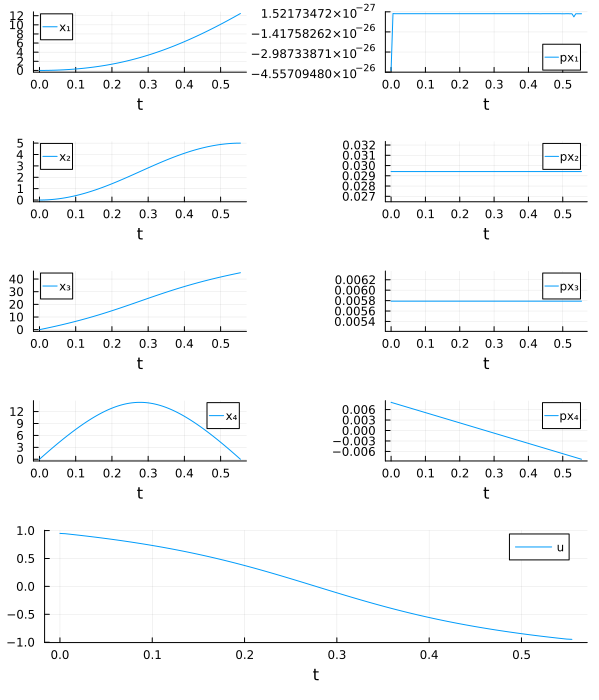

In [7]:
# Plot results
sol = OptimalControlSolution(docp; primal=nlp_sol.solution, dual=nlp_sol.multipliers)
plot(sol)

## 3. Comparison <a id='comp'></a>

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\hajje\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


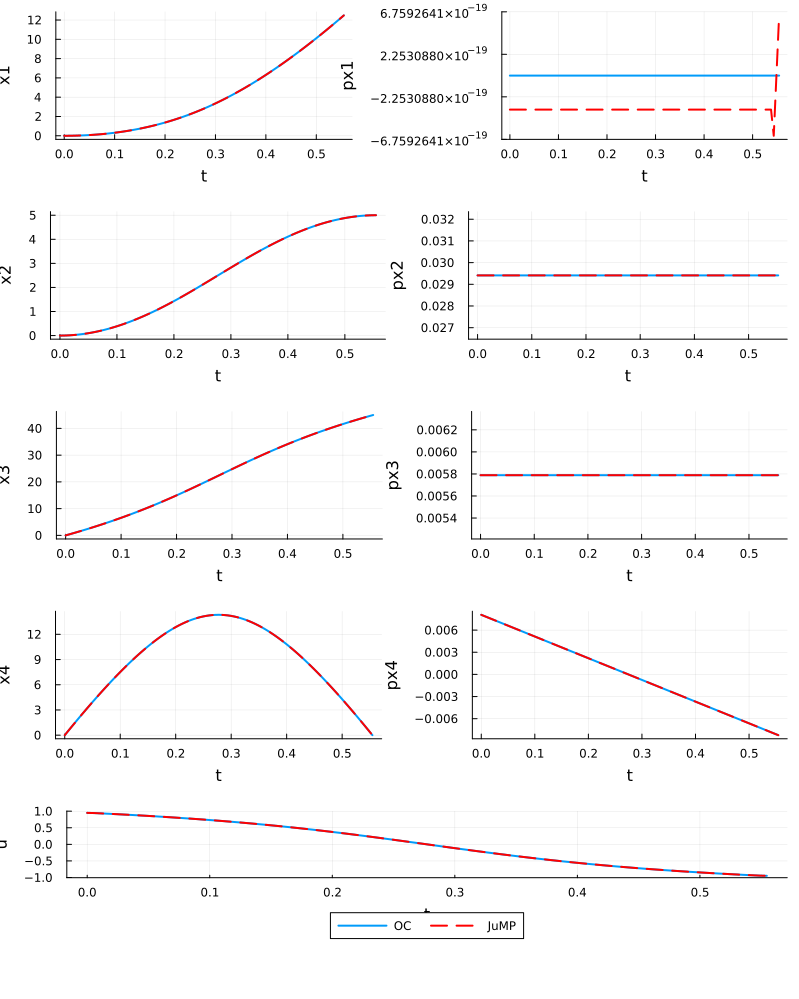

In [8]:
p1 = plot(plot(sol)[1],line = 2)
p1 = plot!(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x1", legend = false,line = 2, color = "red",linestyle=:dash)

p3 = plot(plot(sol)[2],line = 2)
p3 = plot!(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "x2", legend = false,line = 2, color = "red",linestyle=:dash)

p5 = plot(plot(sol)[3],line = 2)
p5 = plot!(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "x3", legend = false,line = 2, color = "red",linestyle=:dash)

p7 = plot(plot(sol)[4],line = 2)
p7 = plot!(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "x4", legend = false,line = 2, color = "red",linestyle=:dash)

p2 = plot(plot(sol)[5],line = 2)
p2 = plot!(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "px1", legend = false,line = 2, color = "red",linestyle=:dash)

p4 = plot(plot(sol)[6],line = 2)
p4 = plot!(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "px2", legend = false,line = 2, color = "red",linestyle=:dash)

p6 = plot(plot(sol)[7],line = 2)
p6 = plot!(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "px3", legend = false,line = 2, color = "red",linestyle=:dash)

p8 = plot(plot(sol)[8],line = 2)
p8 = plot!(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "px4", legend = false,line = 2, color = "red",linestyle=:dash)

p9 = plot(plot(sol)[9] , label ="OC",line = 2)
p9 = plot!(t, [u[i] for i in 1:nh+1 ], xlabel = "t", ylabel = "u", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
p9 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g h; k]
x_plot = plot(p1, p2, p3, p4, p5, p6, p7 , p8, p9, layout = layout, size = (800, 1000))

display(x_plot)